Import

In [1]:
# %pip install pydicom
# %pip install pylibjpeg
# %pip install python_gdcm
# %pip install opencv-python
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install torch
# %pip install torchvision

In [2]:
import pydicom
import pylibjpeg
import gdcm
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image

Load Patient Info

In [3]:
# path = '/Volumes/Seagate Portable Disk/University of Manitoba/Data Science/Datasets/RSNA Breast Cancer/rsna-breast-cancer-detection'
path = '.'
train_img_path = f'{path}/train_images'

train_df = pd.read_csv(f'{path}/train.csv')
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


Training data info

- site_id       : [1,2] 2 Sites, 29K-25K
- patient_id    : Some patients with up to 14 images
- image_id      : unique
- laterality    : [L or R], 50-50
- view          : ['MLO' 'CC' 'AT' 'LM' 'ML', +1], Mostly MLO and CC
- age           : [min = 26, median = 59, max = 89]
- **cancer**        : [0,1] 2% (1.1K) have cancer
- biopsy        : [0,1] 6% (3K) have biopsy
- invasive      : [0,1] 800 cases
- BIRADS        : [0,1,2,nan]
- implant       : [0,1] 2% (1.5K) have implant
- density       : [A,B,C,D,nan] Half is Nan, around 12K for B,C, 3K for A and 1.5K for D
- machine_id    : 10 machines, ~1/2 from {49}, ~1/2 from {48,29,21}
- difficult_negative_case : 7.7K are difficult negative cases

Missing values:
- density and BIRADS are half full
- 37 records with missing age

In [4]:
def get_files(folder):
    fnames = sorted(next(os.walk(folder), (None, None, []))[2])
    fpaths = [f"{folder}/{fname}" for fname in fnames]
    return fnames,fpaths

def get_folders(parent):
    fnames = sorted(next(os.walk(parent), (None, [], None))[1])
    fpaths = [f"{parent}/{fname}" for fname in fnames]
    return fnames,fpaths

def profile(dataframe,missing_values = []) -> pd.DataFrame:
    """
    Summary table for each columns in the dataframe
    """
    dataframe = pd.DataFrame(dataframe)
    ncols = len(dataframe.columns)
    nrows = len(dataframe)
    pf = pd.DataFrame(index = dataframe.columns, columns=["type","count","missing","fill_pct","unique","top5_samples","top5_samples_cnt","mode","min","max","median","mean","std"], dtype=object)
    pf.index.name = "column"
    for col_name in dataframe.columns:
        col_vals = dataframe[col_name]
        col_vals_nonempty = col_vals[col_vals != missing_values] if missing_values else col_vals[col_vals.notna()]
        top5_samples = col_vals.value_counts(ascending=False,dropna=False).iloc[:5]
        pf.loc[col_name,"type"]     = col_vals.dtype.__str__()
        pf.loc[col_name,"count"]    = col_vals.notna().sum()
        pf.loc[col_name,"unique"]   = len(col_vals.unique())
        pf.loc[col_name,"missing"]  = len(col_vals) - len(col_vals_nonempty)
        pf.loc[col_name,"fill_pct"] = np.round(len(col_vals_nonempty)/nrows,2)
        pf.loc[col_name,"top5_samples"] = str(top5_samples.index.values)
        pf.loc[col_name,"top5_samples_cnt"] = str(top5_samples.values)
        pf.loc[col_name,"mode"] = str(col_vals.mode().values)
        if pf.loc[col_name,"type"].startswith(("int","float")):
            pf.loc[col_name,"min"] = np.min(col_vals_nonempty)
            pf.loc[col_name,"max"] = np.max(col_vals_nonempty)
            pf.loc[col_name,"mean"] = np.round(np.mean(col_vals_nonempty),1)
            pf.loc[col_name,"median"] = np.round(np.median(col_vals_nonempty),1)
            pf.loc[col_name,"std"] = np.round(np.std(col_vals_nonempty),1)
    pf = pf.reset_index()
    return pf

profile(train_df)

,column,type,count,missing,fill_pct,unique,top5_samples,top5_samples_cnt,mode,min,max,median,mean,std
0,site_id,int64,54706,0,1.0,2,[1 2],[29519 25187],[1],1,2,1.0,1.5,0.5
1,patient_id,int64,54706,0,1.0,11913,[52868 55706 9795 51115 5421],[14 14 13 13 13],[52868 55706],5,65534,32432.0,32698.9,18893.7
2,image_id,int64,54706,0,1.0,54706,[ 462822612 443006806 587208264 777292277 1...,[1 1 1 1 1],[ 68491 83977 127964 ... 21473553...,68491,2147471846,1082688510.5,1079385987.7,618321265.5
3,laterality,object,54706,0,1.0,2,['R' 'L'],[27439 27267],['R'],NaN,NaN,NaN,NaN,NaN
4,view,object,54706,0,1.0,6,['MLO' 'CC' 'AT' 'LM' 'ML'],[27903 26765 19 10 8],['MLO'],NaN,NaN,NaN,NaN,NaN
5,age,float64,54669,37,1.0,64,[50. 62. 64. 54. 57.],[2248 2038 2011 2004 1964],[50.],26.0,89.0,59.0,58.5,10.1
6,cancer,int64,54706,0,1.0,2,[0 1],[53548 1158],[0],0,1,0.0,0.0,0.1
7,biopsy,int64,54706,0,1.0,2,[0 1],[51737 2969],[0],0,1,0.0,0.1,0.2
8,invasive,int64,54706,0,1.0,2,[0 1],[53888 818],[0],0,1,0.0,0.0,0.1
9,BIRADS,float64,26286,28420,0.48,4,[nan 1. 0. 2.],[28420 15772 8249 2265],[1.],0.0,2.0,1.0,0.8,0.6


In [5]:
test_df = pd.read_csv(f'{path}/test.csv')
test_df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


Further EDA

In [6]:
# Load a patient
cancer_negative_imgs = (train_df['cancer']==0)
cancer_positive_imgs = (train_df['cancer']==1)
diff_cancer_neg_imgs = (train_df['difficult_negative_case']==True)

# sample_cancer_neg_patient = (train_df['patient_id'] == train_df.loc[cancer_negative_imgs,'patient_id'].sample(1,random_state=1).item())
# sample_cancer_pos_patient = (train_df['patient_id'] == train_df.loc[cancer_positive_imgs,'patient_id'].sample(1,random_state=1).item())
# sample_diff_neg_patient = (train_df['patient_id'] == train_df.loc[diff_cancer_neg_imgs,'patient_id'].sample(1,random_state=1).item())

sample_cancer_neg_patient = train_df['patient_id'] == 11294 
sample_cancer_pos_patient = train_df['patient_id'] == 10130
sample_diff_neg_patient = train_df['patient_id'] == 1154

In [7]:
# a = train_df[train_df['difficult_negative_case']==True].value_counts('patient_id',ascending=False)
# a[a<=6]

In [8]:
train_df.loc[sample_cancer_neg_patient] 

column,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
1214,1,11294,812228127,L,MLO,45.0,0,0,0,1.0,0,C,49,False
1215,1,11294,895146777,L,CC,45.0,0,0,0,1.0,0,C,49,False
1216,1,11294,1824102234,L,CC,45.0,0,0,0,1.0,0,C,49,False
1217,1,11294,1349602681,R,MLO,45.0,0,0,0,1.0,0,C,49,False
1218,1,11294,1409066065,R,CC,45.0,0,0,0,1.0,0,C,49,False
1219,1,11294,1747838179,R,CC,45.0,0,0,0,1.0,0,C,49,False


In [9]:
train_df.loc[sample_cancer_pos_patient]

column,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
91,1,10130,1013166704,R,CC,71.0,0,0,0,NaN,0,B,49,False
92,1,10130,1165309236,R,CC,71.0,0,0,0,NaN,0,B,49,False
93,1,10130,2110820077,R,MLO,71.0,0,0,0,NaN,0,B,49,False


In [10]:
train_df.loc[sample_diff_neg_patient]

column,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
1461,1,1154,125663785,L,CC,41.0,0,0,0,0.0,0,B,49,True
1462,1,1154,558831999,L,CC,41.0,0,0,0,0.0,0,B,49,True
1463,1,1154,1385990502,L,MLO,41.0,0,0,0,0.0,0,B,49,True
1464,1,1154,647104804,R,CC,41.0,0,0,0,0.0,0,B,49,True
1465,1,1154,1253815986,R,CC,41.0,0,0,0,0.0,0,B,49,True
1466,1,1154,1737379817,R,MLO,41.0,0,0,0,0.0,0,B,49,True


#patients with only neg imgs =  11427 

#patients with only pos imgs =  6

#patients with both neg and pos imgs = 480

Load Images

Original Dataset

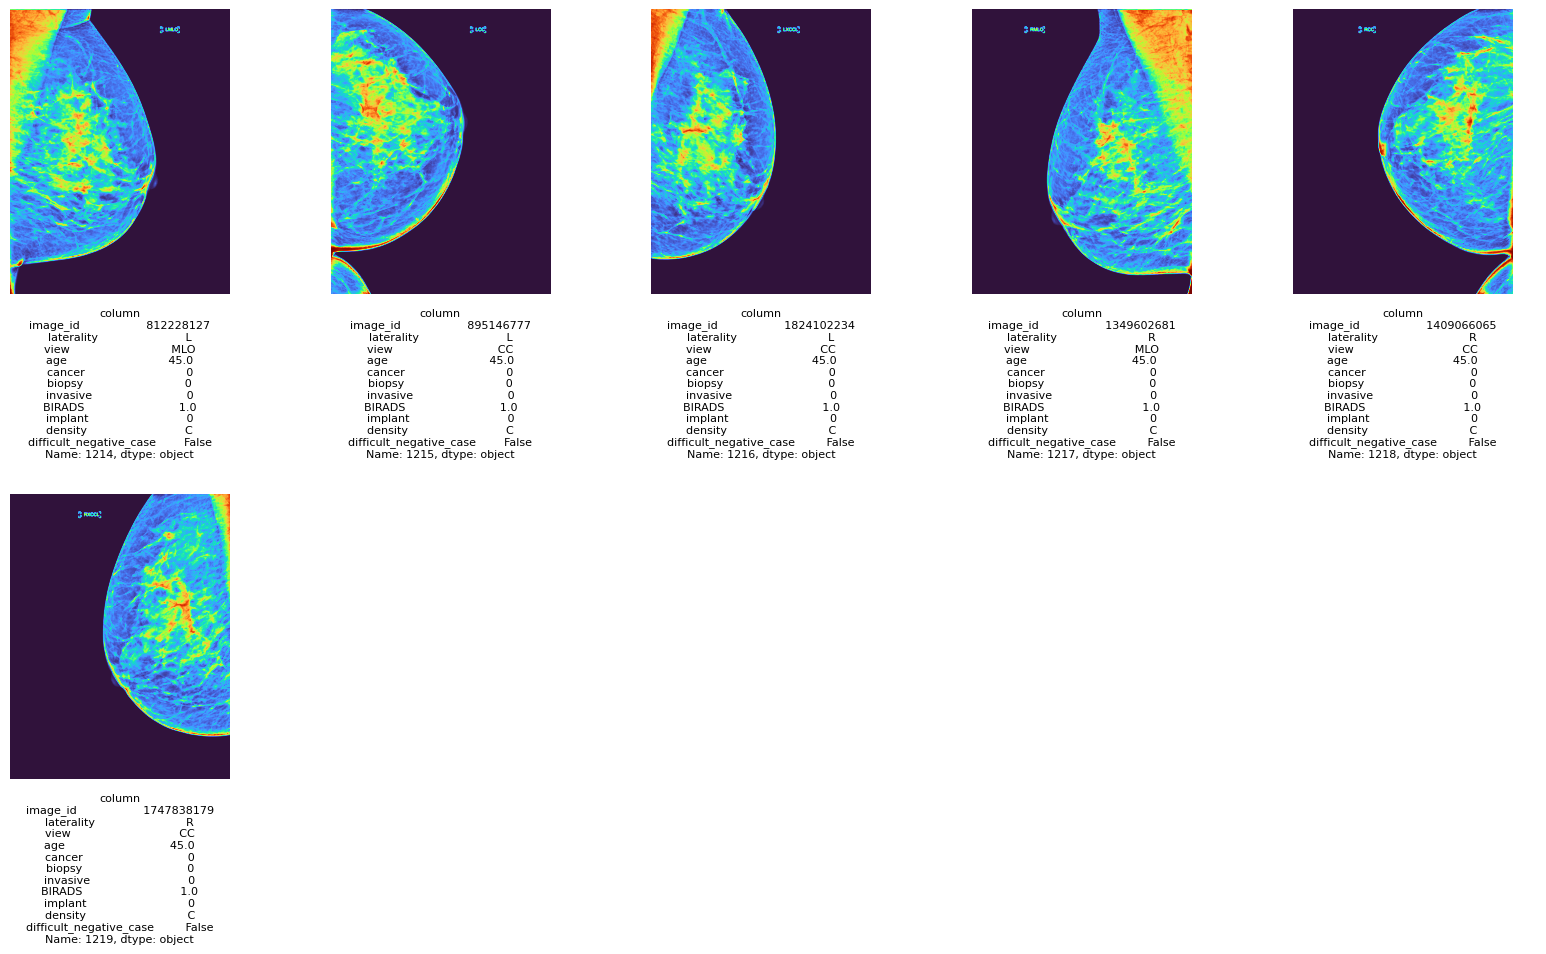

In [11]:
def read_dcm(path):
    return pydicom.dcmread(path).pixel_array

def plot_img(img,ax=plt,cmap='turbo'):
    ax.axis("off")
    ax.imshow(img, cmap=cmap)


def plot_patient(patient_id,path):
    patient_info = train_df[train_df['patient_id'] == patient_id]
    nrows = len(patient_info)//5 + 1
    ncols = 5
    fig, axs = plt.subplots(nrows, ncols, figsize=(min(20,ncols*5),nrows*5))
    plt.subplots_adjust(hspace=0.7)
    axs = axs.flatten()
    for ax in axs:
        ax.axis("off")
    for k,(_,img_row) in enumerate(patient_info.iterrows()):
        img = read_dcm(f'{path}/{patient_id}/{img_row["image_id"]}.dcm')
        plot_img(img,ax=axs[k])
        axs[k].set_title(f"{img_row.drop(['site_id','patient_id','machine_id'])}",fontsize = 8, weight=None,y=-0.60)


patient_id = 11294
plot_patient(patient_id,train_img_path)

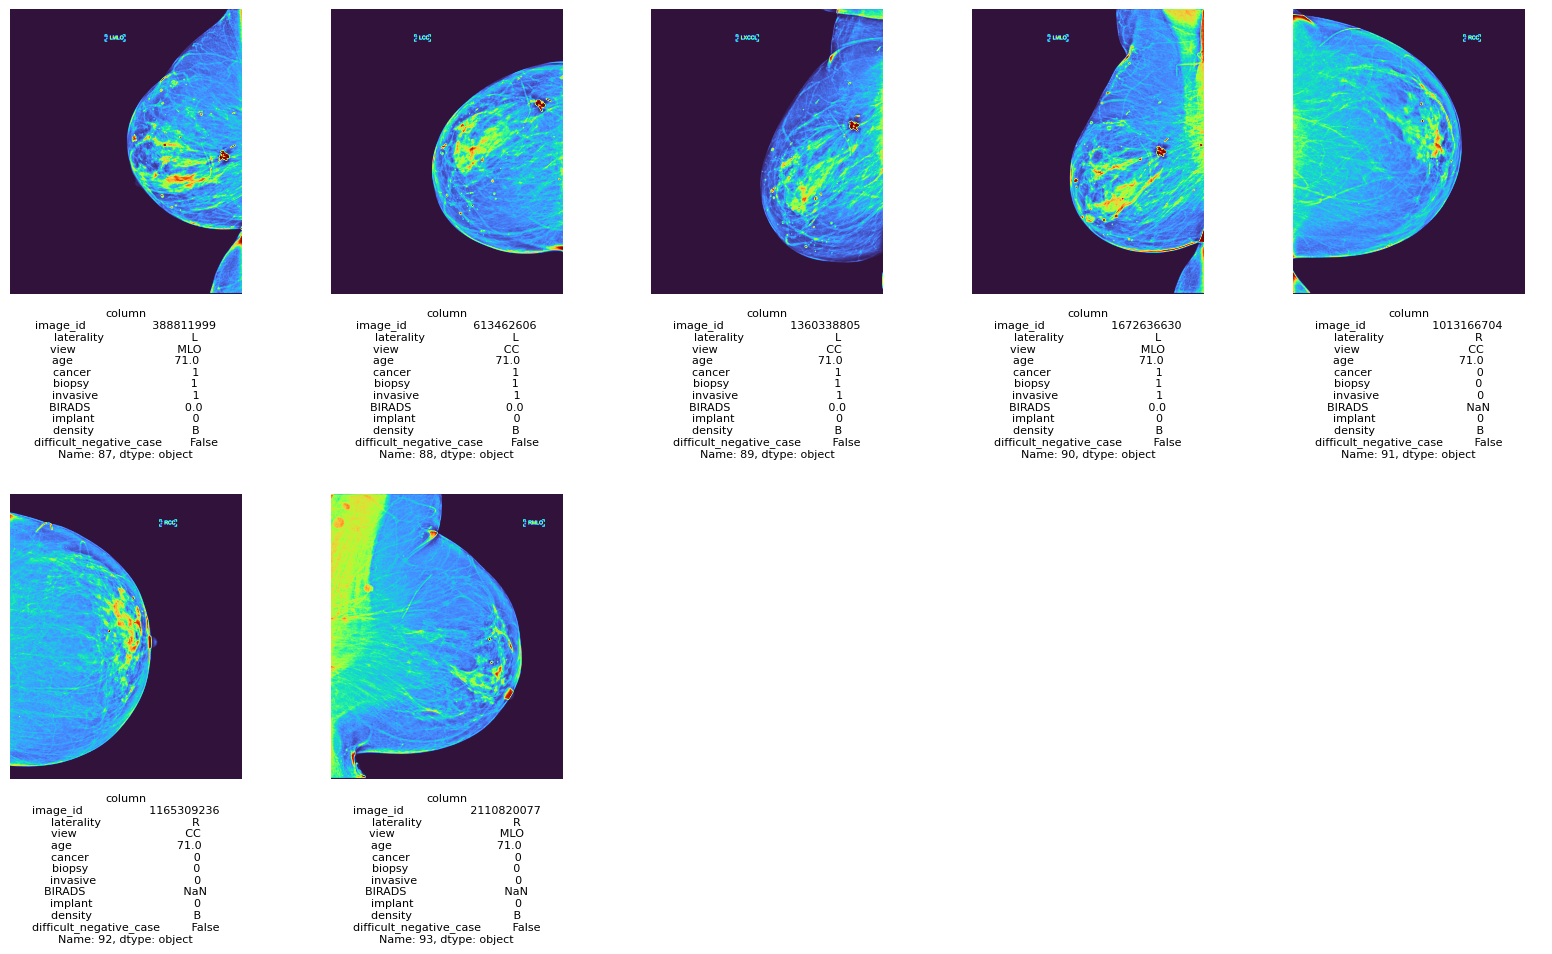

In [12]:
patient_id = 10130
plot_patient(patient_id,train_img_path)

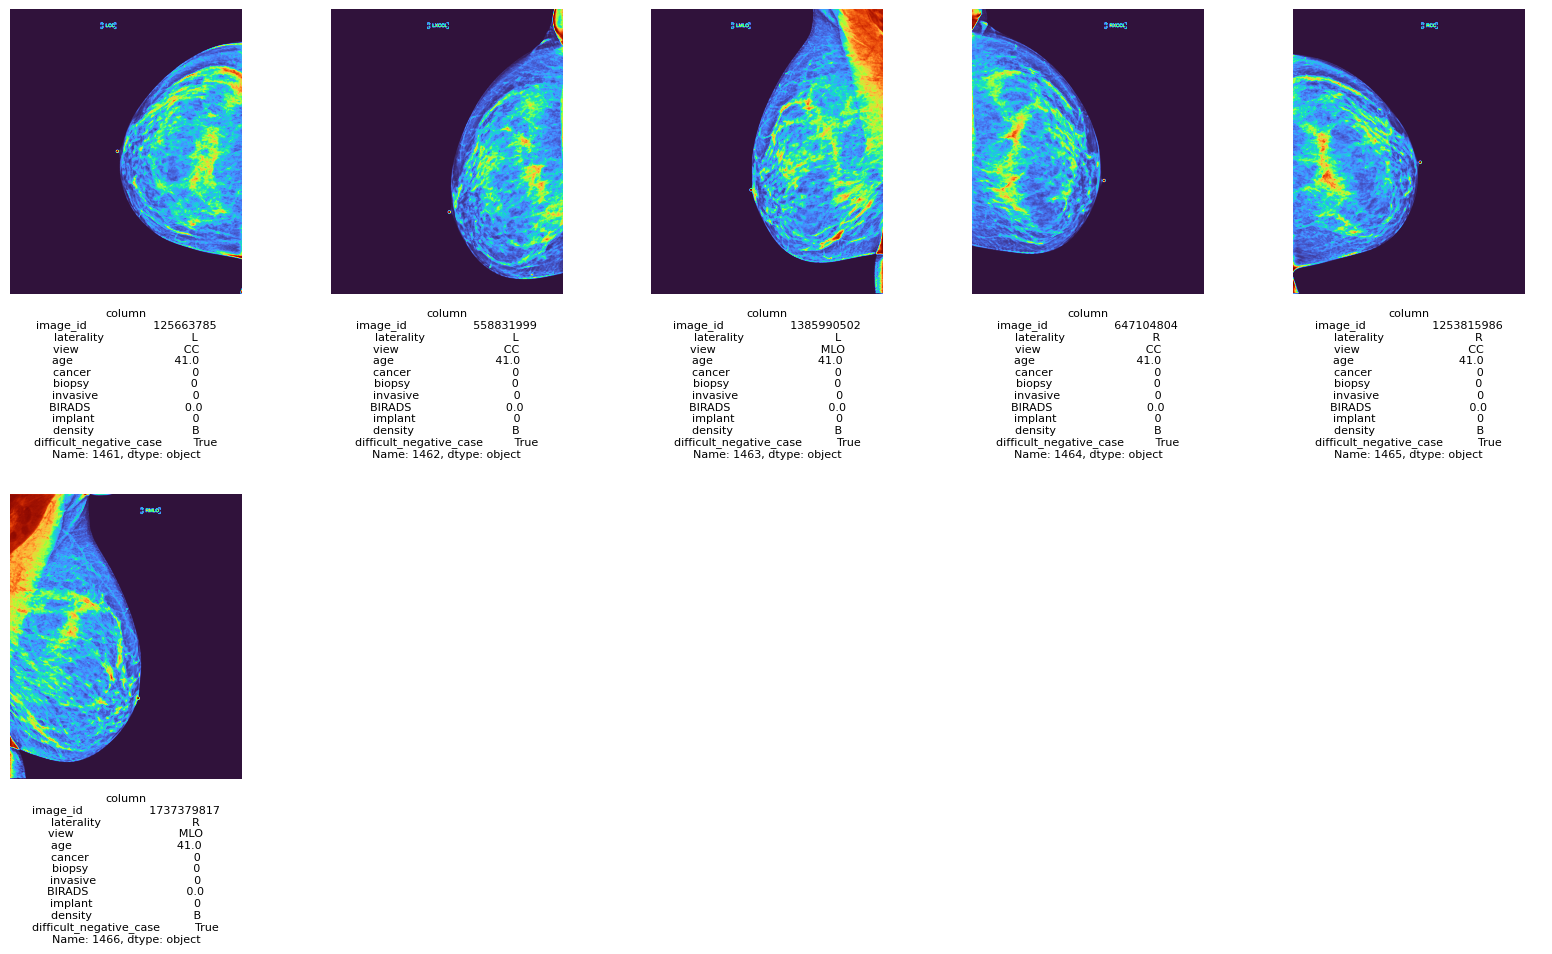

In [13]:
patient_id = 1154
plot_patient(patient_id,train_img_path)

## 256px Dataset

Original image resolution

(3328, 2560) [0, 4095]


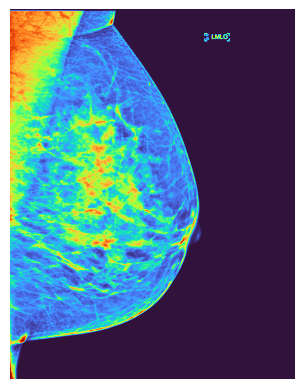

In [14]:
patient_id = 11294
image_id = 812228127
img_path_dcm = f'{train_img_path}/{patient_id}/{image_id}.dcm'
img = read_dcm(img_path_dcm)
print(img.shape,[img.min(),img.max()])
plot_img(img)

Resized image (from https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs)

(256, 256) [0, 255]


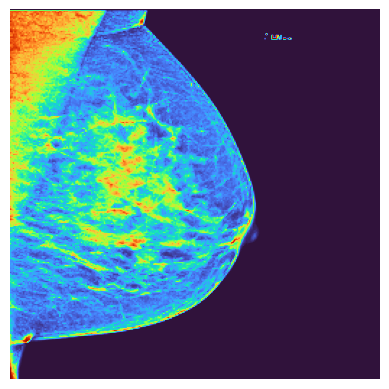

In [15]:
img_path_png = f'256px/{patient_id}_{image_id}.png'
img = np.array(Image.open(img_path_png))
print(img.shape,[img.min(),img.max()])
plot_img(img)

## Data Preprocessing

In [16]:
train_df['laterality'] = LabelEncoder().fit_transform(train_df['laterality'])
train_df['view'] = LabelEncoder().fit_transform(train_df['view'])
train_df['density'] = LabelEncoder().fit_transform(train_df['density'])
train_df['difficult_negative_case'] = train_df['difficult_negative_case'].astype(float)
train_df['img_path'] = f"{path}/256px/" + train_df['patient_id'].astype(str) + "_" + train_df['image_id'].astype(str) + ".png"
train_cols = train_df.columns.drop(['site_id','machine_id'])	
train_df = train_df[train_cols]
train_df

column,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,img_path
0,10006,462822612,0,1,61.0,0,0,0,NaN,0,4,0.0,./256px/10006_462822612.png
1,10006,1459541791,0,5,61.0,0,0,0,NaN,0,4,0.0,./256px/10006_1459541791.png
2,10006,1864590858,1,5,61.0,0,0,0,NaN,0,4,0.0,./256px/10006_1864590858.png
3,10006,1874946579,1,1,61.0,0,0,0,NaN,0,4,0.0,./256px/10006_1874946579.png
4,10011,220375232,0,1,55.0,0,0,0,0.0,0,4,1.0,./256px/10011_220375232.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,0,0,1.0,0,2,0.0,./256px/9973_1729524723.png
54702,9989,63473691,0,5,60.0,0,0,0,NaN,0,2,0.0,./256px/9989_63473691.png
54703,9989,1078943060,0,1,60.0,0,0,0,NaN,0,2,0.0,./256px/9989_1078943060.png
54704,9989,398038886,1,5,60.0,0,0,0,0.0,0,2,1.0,./256px/9989_398038886.png


## Data Subset Sampling

Make sure the computer doesn't explode : )

In [30]:
def sample(df,n,random_state,dropna=True):
    sampled_df = pd.DataFrame()
    remaining_df = df.copy().dropna() if dropna else df.copy()
    for col in remaining_df.columns:
        for val in pd.unique(remaining_df[col]):
            if pd.isna(val):
                df_col = remaining_df[remaining_df[col].isna()]
            else:
                df_col = remaining_df[remaining_df[col] == val]
            sampled = df_col.sample(min(n,len(df_col)),random_state=random_state,replace=False)
            sampled_df = pd.concat([sampled_df,sampled])
            remaining_df = remaining_df.loc[remaining_df.index.difference(sampled_df.index)]
    return sampled_df.drop_duplicates()

train_rows = sample(train_df[train_cols.drop(['patient_id','image_id','age','img_path'])],n=5,random_state=42,dropna=True).index
train_samples = train_df.loc[train_rows]
# train_samples.to_csv('train_samples.csv')
train_samples

column,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,img_path
40044,53266,1392675814,0,5,64.0,0,0,0,0.0,0,1,1.0,./256px/53266_1392675814.png
21271,32577,174870874,0,5,55.0,0,0,0,1.0,0,0,0.0,./256px/32577_174870874.png
23610,35166,1516160364,0,5,65.0,0,0,0,1.0,0,1,0.0,./256px/35166_1516160364.png
37602,5039,1791033919,0,1,54.0,0,1,0,0.0,0,0,1.0,./256px/5039_1791033919.png
38216,51017,1487691247,1,1,57.0,0,0,0,2.0,0,0,0.0,./256px/51017_1487691247.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25696,37463,1170853933,0,1,73.0,0,0,0,0.0,0,0,1.0,./256px/37463_1170853933.png
9782,20437,1400440783,1,1,62.0,0,0,0,1.0,0,0,0.0,./256px/20437_1400440783.png
169,10208,1922025927,1,5,56.0,0,0,0,0.0,0,2,1.0,./256px/10208_1922025927.png
45970,59457,1298923508,0,1,64.0,0,0,0,2.0,0,1,0.0,./256px/59457_1298923508.png


In [29]:
profile(train_samples)

,column,type,count,missing,fill_pct,unique,top5_samples,top5_samples_cnt,mode,min,max,median,mean,std
0,patient_id,int64,71,0,1.0,71,[53266 16072 55761 18026 60519],[1 1 1 1 1],[ 441 1511 4045 5039 5841 6107 9910 102...,441,62183,37092.0,34954.9,17708.1
1,image_id,int64,71,0,1.0,71,[1392675814 1909904463 123539528 1905432390 1...,[1 1 1 1 1],[ 2167850 12193099 106495931 123539528 ...,2167850,2144707732,1288701276.0,1180765157.7,607330426.8
2,laterality,int32,71,0,1.0,2,[1 0],[37 34],[1],0,1,1.0,0.5,0.5
3,view,int32,71,0,1.0,6,[1 5 0 4 2],[29 28 5 4 4],[1],0,5,2.0,2.8,2.0
4,age,float64,71,0,1.0,35,[55. 58. 64. 67. 57.],[6 5 3 3 3],[55.],40.0,89.0,58.0,59.2,11.0
5,cancer,int64,71,0,1.0,2,[0 1],[59 12],[0],0,1,0.0,0.2,0.4
6,biopsy,int64,71,0,1.0,2,[0 1],[49 22],[0],0,1,0.0,0.3,0.5
7,invasive,int64,71,0,1.0,2,[0 1],[63 8],[0],0,1,0.0,0.1,0.3
8,BIRADS,float64,71,0,1.0,3,[0. 1. 2.],[36 22 13],[0.],0.0,2.0,0.0,0.7,0.8
9,implant,int64,71,0,1.0,2,[0 1],[65 6],[0],0,1,0.0,0.1,0.3


# Baseline Models

Courtesy of https://www.kaggle.com/code/andradaolteanu/rsna-breast-cancer-eda-pytorch-baseline

PyTorch